In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from kerod.core.standard_fields import BoxField, DatasetField
from kerod.dataset.preprocessing import preprocess_coco_example
import functools

batch_size = 4

padded_shape = ({
  DatasetField.IMAGES: [None, None, 3],
  DatasetField.IMAGES_INFO: [2],
  DatasetField.IMAGES_PMASK: [None, None]
},
{
  BoxField.BOXES: [None, 4],
  BoxField.LABELS: [None],
  BoxField.NUM_BOXES: [1],
  BoxField.WEIGHTS: [None]
})

ds_train, ds_info = tfds.load(name="coco/2017", split="train", shuffle_files=True, with_info=True)
ds_train = ds_train.map(functools.partial(preprocess_coco_example, bgr=True padded_mask=True),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Filter example with no boxes after preprocessing
ds_train =  ds_train.filter(lambda x, y: tf.shape(y[BoxField.BOXES])[0] > 1)
ds_train =  ds_train.padded_batch(batch_size, padded_shape)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = tfds.load(name="coco/2017", split="validation", shuffle_files=False)
ds_val = ds_val.map(functools.partial(preprocess_coco_example, horizontal_flip=False, bgr=True, padded_mask=True),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Filter example with no boxes after preprocessing
ds_val =  ds_val.filter(lambda x, y: tf.shape(y[BoxField.BOXES])[0] > 1)
ds_val =  ds_val.padded_batch(batch_size, padded_shape)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

## Create an iterator on a small subset of the dataset

In [2]:
# Create an iterator to feed to tensorflow dataset
train_tf = ([x for x in ds_train.take(1)])
ds_train = tf.data.Dataset.from_generator(
    lambda: train_tf,
    ({
        DatasetField.IMAGES: tf.float32,
        DatasetField.IMAGES_INFO: tf.float32,
        DatasetField.IMAGES_PMASK: tf.int8
    }, {
        "bbox": tf.float32,
        "label": tf.int32,
        "num_boxes": tf.int32,
        "weights": tf.float32
    }),
    output_shapes=(
        {
            DatasetField.IMAGES: tf.TensorShape((batch_size, None, None, 3)),
            DatasetField.IMAGES_INFO: tf.TensorShape((batch_size, 2)),
            DatasetField.IMAGES_PMASK: tf.TensorShape((batch_size, None, None))
        
        {
            "bbox": tf.TensorShape((batch_size, None, 4)),
            "label": tf.TensorShape((batch_size, None)),
            "num_boxes": tf.TensorShape((batch_size, 1)),
            "weights": tf.TensorShape((batch_size, None))
        },
    ),
)


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='coco',
    version=1.1.0,
    description='COCO is a large-scale object detection, segmentation, and
captioning dataset. This version contains images, bounding boxes "
and labels for the 2017 version.
Note:
 * Some images from the train and validation sets don't have annotations.
 * Coco 2014 and 2017 uses the same images, but different train/val/test splits
 * The test split don't have any annotations (only images).
 * Coco defines 91 classes but the data only uses 80 classes.
 * Panotptic annotations defines defines 200 classes but only uses 133.',
    homepage='http://cocodataset.org/#home',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'image/id': tf.int64,
        'objects': Sequence({
            'area': tf.int64,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'id': tf.int64,
            'is_crowd': tf.bool,
 

# Load and train the network

Perfom an overfit

In [4]:
import tensorflow_addons as tfa

def downscale_backbone_grads(grads_and_vars):
    """Allow to decrease the gradients by 0.1 for the backbone like in the paper.
    Decreasing the gradients is equivalent to decreasing the learning rate by 0.1
    """
    variables_backbone = {var.name for var in detr.backbone.trainable_variables}
    return [(0.1 * g if v.name in variables_backbone else g, v)
            for g, v in grads_and_vars]

optimizer = tfa.optimizers.AdamW(weight_decay=10e-4,
                                 learning_rate=10e-4,
                                 gradient_transformers=None) #[downscale_backbone_grads])

In [ ]:
from kerod.core.standard_fields import BoxField
from kerod.model import factory
from kerod.model.factory import KerodModel
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Number of classes of Pascal Voc
classes = ds_info.features['objects']['label'].names
num_classes = len(classes)

detr = factory.build_model(num_classes, name=KerodModel.detr_resnet50)

detr.compile(optimizer=optimizer, loss=None)

detr.fit(ds_train, epochs=200)

Epoch 1/200


1/1 [==============================] - 52s 52s/step - loss: 3.9518 - giou: 1.6555 - mae: 0.2472 - scc: 1.4910 - sparse_categorical_accuracy: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 29s 29s/step - loss: 2.5183 - giou: 1.0161 - mae: 0.4464 - scc: 0.4978 - sparse_categorical_accuracy: 0.3172 - recall: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 28s 28s/step - loss: 3.0784 - giou: 1.0318 - mae: 0.4046 - scc: 1.0816 - sparse_categorical_accuracy: 0.3793 - recall: 0.5902
Epoch 4/200
1/1 [==============================] - 27s 27s/step - loss: 2.4517 - giou: 1.0760 - mae: 0.3522 - scc: 0.4605 - sparse_categorical_accuracy: 0.3519 - recall: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 27s 27s/step - loss: 2.4421 - giou: 1.0435 - mae: 0.3624 - scc: 0.4708 - sparse_categorical_accuracy: 0.3530 - recall: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 27s 27s/step - loss: 2.4291 - giou: 1.0600 - mae: 0.3490

## Visualize overfit

In [ ]:
from kerod.utils.drawing import BoxDrawer, draw_bounding_boxes

for i, (features, gt) in enumerate(ds_train):
    draw_bounding_boxes(features['images'][0],
                gt['bbox'][0],
                resize=False)
    if i==10:
        break

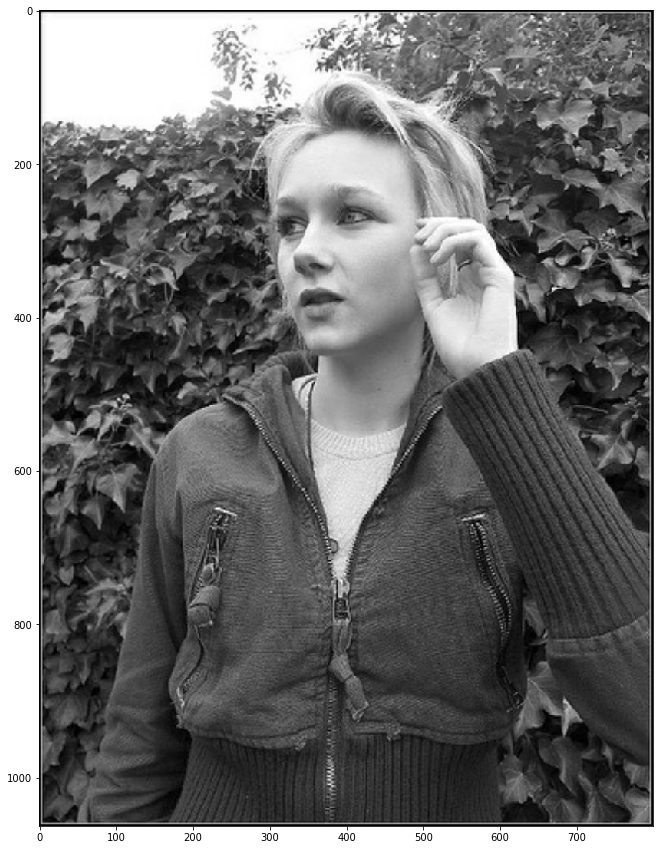

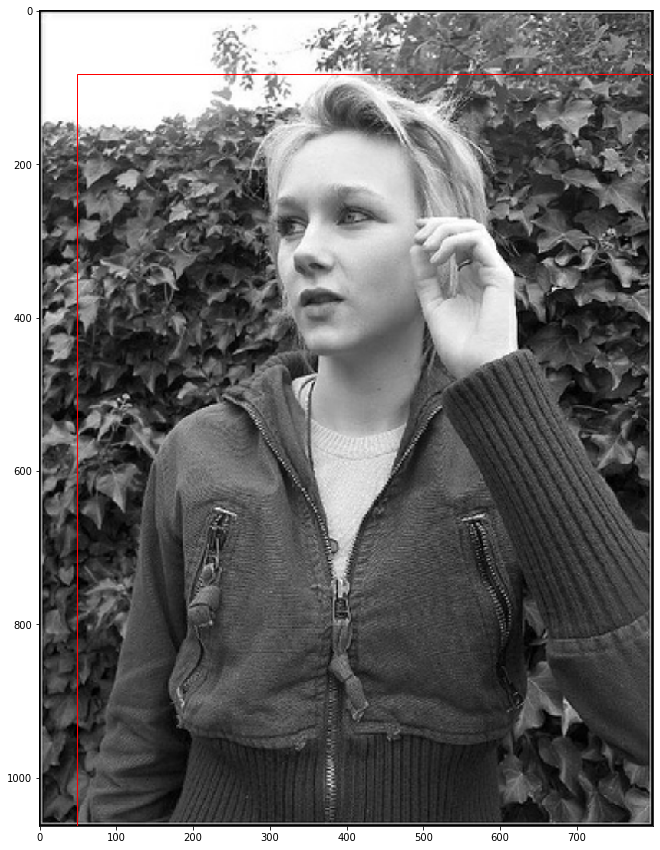

In [6]:
from kerod.utils.drawing import BoxDrawer, draw_bounding_boxes

drawer = BoxDrawer(classes)

for example in ds_train:
    out = detr.predict_on_batch(example[0])
    boxes, scores, labels  = out
    drawer(
        example[0]['images'],
        boxes,
        scores=scores,
        labels=labels,
        num_valid_detections=[10]
    )
    draw_bounding_boxes(example[0]['images'][0],
                example[1]['bbox'][0],
                resize=False)

In [ ]:
import pdb; pdb.set_trace()

--Call--
> /home/egarreau/.pyenv/versions/3.6.6/envs/tensorflow/lib/python3.6/site-packages/IPython/core/displayhook.py(252)__call__()
-> def __call__(self, result=None):
(Pdb) list
247  	    def finish_displayhook(self):
248  	        """Finish up all displayhook activities."""
249  	        sys.stdout.write(self.shell.separate_out2)
250  	        sys.stdout.flush()
251  	
252  ->	    def __call__(self, result=None):
253  	        """Printing with history cache management.
254  	
255  	        This is invoked every time the interpreter needs to print, and is
256  	        activated by setting the variable sys.displayhook to it.
257  	        """
(Pdb) inputs
*** NameError: name 'inputs' is not defined


# Check overfit

To check the overfit it is easier to use the eager mode instead of the classical.

In [5]:
from kerod.core.standard_fields import BoxField
from kerod.core.learning_rate_schedule import WarmupLearningRateScheduler
from kerod.model import factory

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
# Number of classes of Pascal Voc
classes = ds_info.features['labels'].names
num_classes = len(classes)

model_faster_rcnn = factory.build_model(num_classes)

In [3]:
from tensorflow.keras.applications import ResNet50

In [4]:
resnet = ResNet50(input_shape=[224, 224, 3], include_top=False)

In [6]:
name_to_layer = {layer.name: layer for layer in model_faster_rcnn.resnet.layers}

In [7]:
resnet_to_layer= {layer.name: layer for layer in resnet.layers}


In [8]:
name = 'conv3_block1_1_conv'

In [9]:
weights_resnet = resnet_to_layer[name].weights[0].numpy()
weights_frcnn = name_to_layer[name].weights[0].numpy()

In [10]:
import numpy as np
np.testing.assert_array_equal(weights_frcnn, weights_resnet)